In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Constants
VIDEO_HEIGHT, VIDEO_WIDTH = 112, 112
N_FRAMES = 5  # Number of frames per video
BATCH_SIZE = 64  # Batch size
EPOCHS = 200
LEARNING_RATE = 0.00001  # Learning rate for Adam
NUM_CLASSES = 2  # For binary classification (real vs. fake)

# Load metadata CSV
metadata = pd.read_csv('/kaggle/input/hello-21/allmetamix.csv')  # Contains 'Name' and 'Label'

# Map labels to numeric values
label_map = {'REAL': 0, 'FAKE': 1}
metadata['Label'] = metadata['Label'].map(label_map)

# Split metadata into train, validation, and test sets (70%, 15%, 15%)
train_meta, temp_meta = train_test_split(metadata, test_size=0.30, random_state=42, shuffle=True)
val_meta, test_meta = train_test_split(temp_meta, test_size=0.50, random_state=42, shuffle=True)

# Calculate class weights based on the training set
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_meta['Label']),
    y=train_meta['Label']
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Helper function to load preprocessed video
def load_video(video_path, n_frames=N_FRAMES, size=(VIDEO_HEIGHT, VIDEO_WIDTH)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    for i in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break  # Stop reading if no more frames are available
        frame = cv2.resize(frame, size)
        frame = frame.astype(np.float32) / 255.0  # Normalize
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Video Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, metadata, video_dir, batch_size, n_frames, input_size):
        self.metadata = metadata
        self.video_dir = video_dir
        self.batch_size = batch_size
        self.n_frames = n_frames
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_meta = self.metadata.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for _, row in batch_meta.iterrows():
            video_path = os.path.join(self.video_dir, row['Name'])
            frames = load_video(video_path, n_frames=self.n_frames, size=self.input_size)
            X.append(frames)
            y.append(row['Label'])
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.int32)
        return X, y

# Prepare data generators
train_gen = VideoDataGenerator(train_meta, video_dir='/kaggle/input/preprocess12/MIXALL', batch_size=BATCH_SIZE, n_frames=N_FRAMES, input_size=(VIDEO_HEIGHT, VIDEO_WIDTH))
val_gen = VideoDataGenerator(val_meta, video_dir='/kaggle/input/preprocess12/MIXALL', batch_size=BATCH_SIZE, n_frames=N_FRAMES, input_size=(VIDEO_HEIGHT, VIDEO_WIDTH))
test_gen = VideoDataGenerator(test_meta, video_dir='/kaggle/input/preprocess12/MIXALL', batch_size=BATCH_SIZE, n_frames=N_FRAMES, input_size=(VIDEO_HEIGHT, VIDEO_WIDTH))

# Build the DenseNet121 + GRU model
def build_densenet121_gru_model(n_frames, input_size=(VIDEO_HEIGHT, VIDEO_WIDTH, 3)):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(n_frames,) + input_size))
    
    # DenseNet121 for feature extraction
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_size)
    base_model.trainable = True
    model.add(TimeDistributed(base_model, input_shape=(n_frames,) + input_size))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    # GRU for temporal analysis
    model.add(GRU(128, return_sequences=False))
    
    # Dense layers for classification
    model.add(Dense(128, activation='swish'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))  # Single neuron for binary classification
    
    return model

# Build and compile the model
model = build_densenet121_gru_model(n_frames=N_FRAMES)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('deepfake_detector_best_densenet121.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5369 - loss: 0.6986
Epoch 1: val_loss improved from inf to 0.59542, saving model to deepfake_detector_best_densenet121.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.5372 - loss: 0.6984 - val_accuracy: 0.7061 - val_loss: 0.5954 - learning_rate: 1.0000e-05
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7290 - loss: 0.5589
Epoch 2: val_loss improved from 0.59542 to 0.50355, saving model to deepfake_detector_best_densenet121.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7292 - loss: 0.5587 - val_accuracy: 0.7808 - val_loss: 0.5036 - learning_rate: 1.0000e-05
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8335 - loss: 0.4343
Epoch 3: val_loss improved from 0.50355 to 0.41943, saving model to deepfake_detector_best_densenet121.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8336 - loss: 0.4342 - val_accuracy: 0.8315 - val_loss: 0.4194 - learning_rate: 1.00

In [12]:
import json
import matplotlib.pyplot as plt
from keras.models import load_model

# Assuming `model` is your trained model and `history` is from the model.fit call
# Save history to JSON
history_file_path = '/kaggle/working/history.json'  # Path where you want to save history
with open(history_file_path, 'w') as f:
    json.dump(history.history, f)


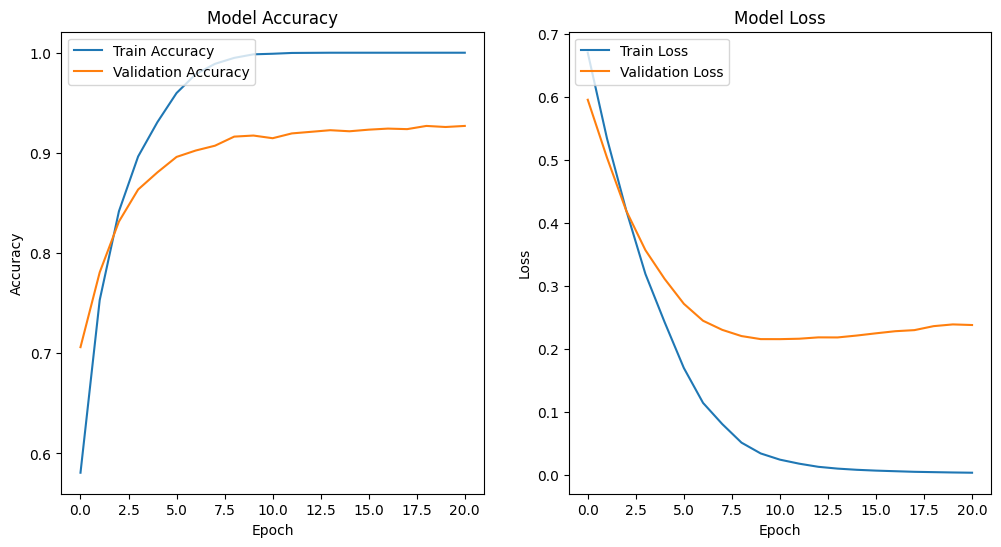

In [13]:
# Load the saved model
model = load_model('/kaggle/working/deepfake_detector_best_densenet121.keras')

# Load the training history from the JSON file
with open(history_file_path, 'r') as f:
    history = json.load(f)

# Plotting function
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

# Example usage
plot_accuracy_and_loss(history)


In [18]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/deepfake_detector_best_densenet121.keras')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ ?                      │     7,037,504 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,324,549 (85.16 MB)

 Trainable params: 7,413,633 (28.28 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 14,827,268 (56.56 MB)

In [25]:
# Create an instance of VideoDataGenerator for the test set
test_flow = VideoDataGenerator(test_meta, video_dir='/kaggle/input/preprocess12/MIXALL', batch_size=BATCH_SIZE, n_frames=N_FRAMES, input_size=(VIDEO_HEIGHT, VIDEO_WIDTH))

# Get predictions from the model using the test flow
y_pred = model.predict(test_flow)

# Collect true labels
y_test = test_flow.metadata['Label'].values  # True labels from the metadata

# Calculate and print the metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 989ms/step
ROC AUC Score: 0.9711127046446474
AP Score: 0.9769140204437701

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       739
           1       0.92      0.96      0.94      1136

    accuracy                           0.92      1875
   macro avg       0.92      0.91      0.92      1875
weighted avg       0.92      0.92      0.92      1875

